# EEG-Based Emotion Recognition Using Regularized Graph Neural Networks
## Cognitive Computing and Artificial Intelligence, 2020/21, Final Project
### Bartolomeo Caruso, Gabriele Costanzo, Giuseppe Fallica

---

First, we defined an "import routine": outside of the regular Colab imports (*torch, numpy, pandas, standard library, etc.*), the RGNN model leverages on specialized torch libraries, such as **torch_geometric**, that need to be installed via **pip**.

The correct version to download is obtained via workspace informations, such as the version numbers of the *torch* and *CUDA* libraries.

In [ ]:
# Install required packages.
# This code will install the correct version of Pytorch Geometric.
import torch

TORCH_version = torch.__version__
TORCH = TORCH_version.split('+')[0]

CUDA_version = torch.version.cuda
CUDA =  'cu' + CUDA_version.replace('.', '')

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

# Other imports...
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.nn import SGConv, global_add_pool
import torch_geometric
from torch_scatter import scatter_add
from tensorflow.python.client import device_lib
import json
import os

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 2.6MB 7.2MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 1.4MB 8.4MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 931kB 7.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 389kB 8.1MB/s 
     |████████████████████████████████| 225kB 8.2MB/s 
     |████████████████████████████████| 235kB 43.7MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-cp37-none-any.whl size=388143 sha256=5d81728544739e69124eb732c64081ca56ad43561092c73705ca621866b81e5c
  Stored in directory: /root/.cache/pip/wheels/e7/66/5b/ad17ef7f04b7c425dc6930daac160c3747231b0d65f9ac7972
Successfully built torch-geometric


And also setup the available device "**dev**" correctly:

In [ ]:
dev = ("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


---
Following is the code from the original RGNN repository, copy-pasted, commented, and with the following additions added:
- fixed some bugs, i.e. bugs derived by using "*1 - mask*" instead of "*torch.logical_not(mask)*"
- a "*Xavier initialization*" method with uniform distribution was added for the internal weights, as requested in the paper
  - this step is already provided in the default implementation of SGConv, but we're ensuring it (as SGConv has been re-defined in a new class) and adding it to the other layers

In [ ]:
#######################################################################################
# HELPER FUNCTIONS

# maybe_num_nodes: derives the correct number of nodes using the edges, if not given
#
# Parameters:
# - index: Tensor (2, num_edges), see next function
# - num_nodes: number of nodes, if known; it will be otherwise computed from the indices
def maybe_num_nodes(index, num_nodes=None):
    return index.max().item() + 1 if num_nodes is None else num_nodes   # If num_nodes == None, find num_nodes as the max number among the edge indices (+1, as they start from 0)


# add_remaining_self_loops: takes an adjacency matrix in the form of edge_index and edge_weight lists, and adds self loops if not present
#
# Parameters:
# - edge_index: Tensor (2, num_edges), where each col i represent the i-th edge (x, y)
# - edge_weight: Tensor (1, num_edges), which contains the weight of the i-th edge for each col i
# - fill_value=1: value to fill the diagonal with
# - num_nodes: number of nodes present, if known (it will be derived otherwise)
def add_remaining_self_loops(edge_index,
                             edge_weight=None,
                             fill_value=1,
                             num_nodes=None):
    num_nodes = maybe_num_nodes(edge_index, num_nodes)  # Derive num_nodes with "maybe_num_nodes" if unknown
    row, col = edge_index   # obtain the two rows of edge_index as two separate tensors, one of edge rows (x's) and the other of edge cols (y's)
    mask = row != col   # a bit-wise mask of all matrix cells, excluding the diagonal
    inv_mask = torch.logical_not(mask) # inverted mask, that is ONLY the diagonal
    loop_weight = torch.full(     # fill a Tensor (num_nodes, 1) full of fill_value ( = 1)
        (num_nodes, ),
        fill_value,
        dtype=None if edge_weight is None else edge_weight.dtype,
        device=edge_index.device)

    if edge_weight is not None:
        assert edge_weight.numel() == edge_index.size(1)  # Assert that the number of edge_weights is the same as the number of edge_indices couples
        remaining_edge_weight = edge_weight[inv_mask]   # Subset for the edge_weights of edges on the diagonal
        if remaining_edge_weight.numel() > 0:                      # If there was already at least an edge_weight on the diagonal:
            loop_weight[row[inv_mask]] = remaining_edge_weight  # makes it so loop_weight[i] represents the weight on the cell (i,i); sets it to the currently available value, and leaves it at 1 if not present
        edge_weight = torch.cat([edge_weight[mask], loop_weight], dim=0) # Updates edge_weights as concat([ edge_weight[not_diagonal], edge_weight[diagonal] ]), where the edge weights on the diagonal are currently inside loop_weight

    # Repeats the same steps to update and reorder the edge_index values as concat( [ edge_index[not_diagonal], edge_index[diagonal] ] ), by using a tempo loop_index tensor
    loop_index = torch.arange(0, num_nodes, dtype=row.dtype, device=row.device)
    loop_index = loop_index.unsqueeze(0).repeat(2, 1)
    edge_index = torch.cat([edge_index[:, mask], loop_index], dim=1)

    return edge_index, edge_weight


#######################################################################################
# HELPER CLASSES

# NewSGConv(SGConv): super-class of SGConv with some redefinitions to allow negative values in the adjacency matrix
class NewSGConv(SGConv):  # SGConv implements the base SGC computations, such as S=D^(-1/2)AD^(-1/2) and A'=A+I for the self-loops
    def __init__(self, num_features, num_classes, K=1, cached=False,
                 bias=True):
        super(NewSGConv, self).__init__(num_features, num_classes, K=K, cached=cached, bias=bias)

    # N.B.: SGConv implements the adjacency matrix via two separates structures: a list of indices (x, y) of the edges ("edge_index") and a list of their assigned weights ("edge_weight")

    # allow negative edge weights
    @staticmethod
    def norm(edge_index, num_nodes, edge_weight, improved=False, dtype=None):
        if edge_weight is None: # Uses a default edge_weight initialization, if not provided
            edge_weight = torch.ones((edge_index.size(1), ),
                                     dtype=dtype,
                                     device=edge_index.device)

        fill_value = 1 if not improved else 2
        edge_index, edge_weight = add_remaining_self_loops( # adds the remaining self-loops, if necessary
            edge_index, edge_weight, fill_value, num_nodes)
        row, col = edge_index

        # N.B.: scatter_add creates a Tensor (num_nodes, 1) "deg" where "deg[i] = sum(A_i, i=0) -> puts in deg[i] the sum of row i of A
        deg = scatter_add(torch.abs(edge_weight), row, dim=0, dim_size=num_nodes) # torch.abs is required because A contains negative values, see chap 4.2.0 in the paper
        deg_inv_sqrt = deg.pow(-0.5)  # computes D^(-1/2)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0  # deletes "inf" values

        return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]  # Returns  S=D^(-1/2)AD^(-1/2), optimized by using a 1-dimensional tensor instead of 2D diagonal matrices

# N.B. "forward" is a redefinition of SGConv's forward method, done to use the here defined "norm" method for normalization, in substitution of the default "gcn_norm"
    def forward(self, x, edge_index, edge_weight=None):
        """"""
        if not self.cached or self.cached_result is None:
            edge_index, norm = NewSGConv.norm(  # Returns normalized edge_index and edge_weights
                edge_index, x.size(0), edge_weight, dtype=x.dtype)

            for k in range(self.K):   # see chap 3.1.0, fig.4; we assume K=2
                x = self.propagate(edge_index, x=x, norm=norm)
            self.cached_result = x

        return self.lin(self.cached_result)

    def message(self, x_j, norm): # called by "self.propagate"
        # x_j: (batch_size*num_nodes*num_nodes, num_features)
        # norm: (batch_size*num_nodes*num_nodes, )
        return norm.view(-1, 1) * x_j

# ReverseLayerF(Function): extends Function, is used in the NodeDAT, both "forward" and "backward" methods are provided for activation and backward propagation
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

#######################################################################################
# THE RGNN MODEL

class SymSimGCNNet(torch.nn.Module):
    def __init__(self, num_nodes, learn_edge_weight, edge_weight, num_features, num_hiddens, num_classes, K, dropout=0.5, domain_adaptation=""):
        """
            num_nodes: number of nodes in the graph
            learn_edge_weight: if True, the edge_weight is learnable
            edge_weight: initial edge matrix
            num_features: feature dim for each node/channel
            num_hiddens: a tuple of hidden dimensions                     # d'
            num_classes: number of emotion classes
            K: number of layers                                                           # L=2
            dropout: dropout rate in final linear layer                           # 0.7
            domain_adaptation: RevGrad
        """
        super(SymSimGCNNet, self).__init__()
        self.domain_adaptation = domain_adaptation
        self.num_nodes = num_nodes
        self.xs, self.ys = torch.tril_indices(self.num_nodes, self.num_nodes, offset=0) # cols and rows of edge_index
        edge_weight = edge_weight.reshape(self.num_nodes, self.num_nodes)[self.xs, self.ys] # strict lower triangular values
        self.edge_weight = nn.Parameter(edge_weight, requires_grad=learn_edge_weight) # edge_weight as lower triangular is set as a learnable parameter
        self.dropout = dropout
        # LAYERS
        self.conv1 = NewSGConv(num_features=num_features, num_classes=num_hiddens[0], K=K)  # a K-layer SGC
        self.fc = nn.Linear(num_hiddens[0], num_classes)  # an output linear classification layer [d' * C] 
        # NODE-DAT
        if self.domain_adaptation in ["RevGrad"]:
            self.domain_classifier = nn.Linear(num_hiddens[0], 2) # also creates an output layer [d' * 2] for the NodeDAT

        self.apply(self.weight_init) # apply the following function

    # function for the Xavier initialization of the weights with uniform distribution
    def weight_init(self,m):
      if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
      if isinstance(m, NewSGConv):
        nn.init.xavier_uniform_(m.lin.weight)

    def forward(self, data, alpha=0):
        # "data" created using the Data class, see: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-handling-of-graphs
        # "alpha" corresponds to the paper's Beta parameter in the NodeDAT adversarial training
        batch_size = len(data.y)
        x, edge_index = data.x, data.edge_index

        # Create a local copy of the edge_weight, as upper triangular
        edge_weight = torch.zeros((self.num_nodes, self.num_nodes), device=edge_index.device)
        edge_weight[self.xs.to(edge_weight.device), self.ys.to(edge_weight.device)] = self.edge_weight
        edge_weight = edge_weight + edge_weight.transpose(1,0) - torch.diag(edge_weight.diagonal()) # copy values from lower tri to upper tri

        # Repeat edge_weight batch_size times
        edge_weight = edge_weight.reshape(-1).repeat(batch_size)
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        
        # domain classification
        domain_output = None
        if self.domain_adaptation in ["RevGrad"]:
            reverse_x = ReverseLayerF.apply(x, alpha) # forward step in ReverseLayerF
            domain_output = self.domain_classifier(reverse_x)
        x = global_add_pool(x, data.batch, size=batch_size) # Node-wise sum pooling
        x = F.dropout(x, p=self.dropout, training=self.training) # Dropout
        x = self.fc(x)  # Linear output
        return x, domain_output

---

Before defining the next dataset-loading methods, we need to connect to the local Google Drive directories.
We used the SEED_IV folder provided by the dataset's curators as-is, and added a single file in the main folder.

Called **"channel_locations.txt"**, it contains the 3D coordinates of the electrodes for a correct computation of the distances, in order to initialize the adjacency matrix correctly and according to the paper, rather than randomly.

In [ ]:
# Define root directory from Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
root_dir = "/content/drive/My Drive/SEED_IV/"

Mounted at /content/drive


The following functions use the "Channel Order.xlsx" and "channel_locations.txt" files, as well as info from the paper about the global channels' couples, to initialize the adjacency matrix as a (62, 62) Tensor.

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix

# Functions for creating a correctly initialized adjacency matrix
def global_channels(adjacency_matrix, filtered_channels, channel_tuples):
  for channel1,channel2 in channel_tuples:  # Update the global channel values as "value = value - 1"
    adjacency_matrix[filtered_channels.index(channel1), filtered_channels.index(channel2)] = adjacency_matrix[filtered_channels.index(channel1), filtered_channels.index(channel2)] - 1
    adjacency_matrix[filtered_channels.index(channel2), filtered_channels.index(channel1)] = adjacency_matrix[filtered_channels.index(channel2), filtered_channels.index(channel1)] - 1
  return adjacency_matrix

def get_adjacency_matrix():
  channel_order = pd.read_excel(root_dir+"Channel Order.xlsx", header=None) # Use the Excel sheet for indexing, as the "channel_locations.txt" file contains extra rows
  channel_location = pd.read_csv(root_dir+"channel_locations.txt", sep= "\t", header=None)
  channel_location.columns = ["Channel", "X", "Y", "Z"]
  channel_location["Channel"] = channel_location["Channel"].apply(lambda x: x.strip().upper())
  filtered_df = pd.DataFrame(columns=["Channel", "X", "Y", "Z"])
  for channel in channel_location["Channel"]:
    for used in channel_order[0]:
      if channel == used:
        filtered_df = pd.concat([channel_location.loc[channel_location['Channel'] == channel], filtered_df], ignore_index=True) # Concatenate each row from the "channel_location" dataframe whose channel name is present in the Excel sheet
  filtered_df = filtered_df.reindex(index=filtered_df.index[::-1]).reset_index(drop=True)
  filtered_matrix = np.asarray(filtered_df.values[:, 1:4], dtype=float)
  distances_matrix = distance_matrix(filtered_matrix, filtered_matrix)  # Compute a matrix of distances for each combination of channels in the filtered_matrix dataframe
  delta = 5
  adjacency_matrix = np.minimum(np.ones([62,62]), delta/(distances_matrix**2))  # Computes the adjacency matrix cells as min(1, delta/d_ij), N.B. zero division error can arise here for the diagonal cells, "1" value will be chosen automatically instead
  filtered_channels = list(filtered_df["Channel"])
  adjacency_matrix = global_channels(adjacency_matrix, filtered_channels,
    [("FP1", "FP2"), ("AF3", "AF4"), ("F5", "F6"), ("FC5", "FC6"), ("C5", "C6"), ("CP5", "CP6"), ("P5", "P6"), ("PO5", "PO6"), ("O1", "O2")]  # These couples are taken from the paper, chap. 4.1
  )
  return torch.tensor(adjacency_matrix).float()

The following functions are used to create specialized data loaders for subject-dependent and subject-independent classification.

Both indications in the SEED_IV dataset (i.e. how labels change from one session to another) and ones in the paper (i.e. what training/testing ratio shall be used for each subject-dependent model, or how to perform cross-validation in the subject-indepentent case) were adopted.

For each sample the "de_LDS" features where taken, that is the Differential Entropy computed in the 5 frequency bands using Linear dynamical systems (LDS).

In [ ]:
import scipy.io
import random

# --- Subject dependent ---
def dependent_loaders(batch_size, shuffle):
  session1_label = [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3];
  session2_label = [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1];
  session3_label = [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0];
  labels = [session1_label, session2_label, session3_label]
  eeg_dict = {}
  print("--- SUBJECT DEPENDENT LOADER ---")
  for session in range (1, 4):
    print("WE ARE IN SESSION: {:d}".format(session))
    session_labels = labels[session-1]
    session_folder = "/content/drive/My Drive/SEED_IV/eeg_feature_smooth/"+str(session)
    for file in os.listdir(session_folder):
      p=int(file.split("_")[0])
      file_path = "{}/{}".format(session_folder,file)
      print("THIS IS PATIENT: {:d}".format(p))
      # Objective: create for each subject a dict containing a list of "train" Data objects and a list of "test" Data objects
      if p not in eeg_dict.keys():
          eeg_dict[p] = {
              "train":[],
              "test":[]
          }
      for videoclip in range(24): # There are 24 trials per subject, following the "session_label" label order
        X = scipy.io.loadmat(file_path)['de_LDS{}'.format(videoclip+1)]
        y = session_labels[videoclip]
        y = torch.tensor([y]).long()
        edge_index = torch.tensor([np.arange(62*62)//62, np.arange(62*62)%62])
        for t in range(X.shape[1]):
          x = torch.tensor(X[:, t, :]).float()
          x = (x-x.mean())/x.std()
          if videoclip < 16:  # Put the first 16 in training, and the last 8 in testing
            eeg_dict[p]["train"].append(torch_geometric.data.Data(x=x, y=y, edge_index=edge_index))
          else:
            eeg_dict[p]["test"].append(torch_geometric.data.Data(x=x, y=y, edge_index=edge_index))
  
  loaders_dict = {}

  # Adapt the "train" and "test" Data lists into single DataLoader objects
  for key in eeg_dict.keys():
    loaders_dict[key] = {}
    loaders_dict[key]["train"] = torch_geometric.data.DataLoader(eeg_dict[key]["train"], batch_size=batch_size, shuffle=shuffle)
    loaders_dict[key]["test"] = torch_geometric.data.DataLoader(eeg_dict[key]["test"], batch_size=batch_size, shuffle=shuffle)

  print("--------------------------------\n\n")
  return loaders_dict


# --- Subject independent ---
def independent_loaders(batch_size, shuffle):
  session1_label = [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3];
  session2_label = [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1];
  session3_label = [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0];
  labels = [session1_label, session2_label, session3_label]
  eeg_dict = {}
  print("--- SUBJECT INDEPENDENT LOADER ---")
  for session in range (1, 4):
    print("WE ARE IN SESSION: {:d}".format(session))
    session_labels = labels[session-1]
    session_folder = "/content/drive/My Drive/SEED_IV/eeg_feature_smooth/"+str(session)
    for file in os.listdir(session_folder):
      p=int(file.split("_")[0])
      file_path = "{}/{}".format(session_folder,file)
      print("THIS IS PATIENT: {:d}".format(p))
      # Objective: create for each subject a single list of Data object (all samples of a subject are used as either training or testing)
      if p not in eeg_dict.keys():
          eeg_dict[p] = []
      for videoclip in range(24): # There are 24 trials per subject, following the "session_label" label order
        X = scipy.io.loadmat(file_path)['de_LDS{}'.format(videoclip+1)]
        y = session_labels[videoclip]
        y = torch.tensor([y]).long()
        edge_index = torch.tensor([np.arange(62*62)//62, np.arange(62*62)%62])
        for t in range(X.shape[1]):
          x = torch.tensor(X[:, t, :]).float()
          x = (x-x.mean())/x.std()
          eeg_dict[p].append(torch_geometric.data.Data(x=x, y=y, edge_index=edge_index))
  
  loaders_dict = {}

  # Keep the bare list in a "list" field, and adapt it into a single DataLoader object in a "loader" field
  for key in eeg_dict.keys():
    loaders_dict[key] = {}
    loaders_dict[key]["list"] = eeg_dict[key]
    loaders_dict[key]["loader"] = torch_geometric.data.DataLoader(eeg_dict[key], batch_size=batch_size, shuffle=shuffle)

  print("----------------------------------\n\n")
  return loaders_dict

We're then asked to load the data into batches of 16 samples per batch. We shuffle the samples in the DataLoader classes, to ensure not too many samples with the same label are given in a single batch.

In [ ]:
dep_loader = dependent_loaders(16, True)
indep_loader = independent_loaders(16, True)

--- SUBJECT DEPENDENT LOADER ---
WE ARE IN SESSION: 1
THIS IS PATIENT: 2
THIS IS PATIENT: 3
THIS IS PATIENT: 4
THIS IS PATIENT: 5
THIS IS PATIENT: 6
THIS IS PATIENT: 7
THIS IS PATIENT: 8
THIS IS PATIENT: 9
THIS IS PATIENT: 10
THIS IS PATIENT: 11
THIS IS PATIENT: 12
THIS IS PATIENT: 14
THIS IS PATIENT: 15
THIS IS PATIENT: 1
THIS IS PATIENT: 13
WE ARE IN SESSION: 2
THIS IS PATIENT: 2
THIS IS PATIENT: 3
THIS IS PATIENT: 4
THIS IS PATIENT: 5
THIS IS PATIENT: 6
THIS IS PATIENT: 7
THIS IS PATIENT: 8
THIS IS PATIENT: 9
THIS IS PATIENT: 10
THIS IS PATIENT: 11
THIS IS PATIENT: 12
THIS IS PATIENT: 14
THIS IS PATIENT: 15
THIS IS PATIENT: 1
THIS IS PATIENT: 13
WE ARE IN SESSION: 3
THIS IS PATIENT: 2
THIS IS PATIENT: 3
THIS IS PATIENT: 4
THIS IS PATIENT: 5
THIS IS PATIENT: 6
THIS IS PATIENT: 7
THIS IS PATIENT: 8
THIS IS PATIENT: 9
THIS IS PATIENT: 10
THIS IS PATIENT: 11
THIS IS PATIENT: 12
THIS IS PATIENT: 14
THIS IS PATIENT: 15
THIS IS PATIENT: 1
THIS IS PATIENT: 13
-------------------------------

---
Here we start by defining the functions for the Subject-Dependent and Subject-Independent training sessions.

Default parameters are given in both functions, by giving the possibility to change around the **L1 regularization alpha**, the **noise level** for the Emotion DL regularizer, the **output size** of the convolution (num_hiddens) and the **number of epochs**, as well as the possibility to either use or discard the **Emotion DL** and **NodeDAT** (subject-independent only) regularizers, and to initialize the adjacency matrix either **randomly** or according to distances.

In [ ]:
import math

#--- Subject Dependent ---
def subject_dependent_training(dep_loader, emo_DL=True, rand_adj=False, L1_alpha=0.01, noise_level=0.2, num_hiddens=16, num_epochs=100):
  model_stats = {}
  nodeDAT = ""
  eps3 = noise_level/3
  eps4 = noise_level/4
  emoDL_map = torch.tensor([
      [1-3*eps4, eps4, eps4, eps4],
      [eps3, 1-2*eps3, eps3, 0],
      [eps4, eps4, 1-3*eps4,eps4],
      [eps3, 0, eps3, 1-2*eps3]
  ])

  for i in range(1, 16):
    print("PAZIENTE no. "+str(i)+":")
    loss_history = {'train': [], 'test': []}
    accuracy_history = {'train': [], 'test': []}

    edge_weight = get_adjacency_matrix() if not rand_adj else torch.rand((62,62))
    
    model = SymSimGCNNet(62, True, edge_weight, 5, [num_hiddens], 4, 2, dropout=0.7, domain_adaptation=nodeDAT)
    model = model.to(dev)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    data_loaders = dep_loader[i]
    for epoch in range(num_epochs):
      # Initialize variables for computing average loss/accuracy
      # Initialize epoch variables
      sum_loss = {"train": 0, "test": 0}
      sum_accuracy = {"train": 0, "test": 0}
      # Process each split
      for split in ["train", "test"]:
          # Set network mode (train or eval)
          if split == "train":
            model.train()
            torch.set_grad_enabled(True)
          else:
            model.eval()
            torch.set_grad_enabled(False)
          # Process all data in split
          for batch in data_loaders[split]:
            # Move to CUDA
            batch = batch.to(dev)
            # Reset gradients
            optimizer.zero_grad()
            # Compute output
            pred,_ = model(batch)
            y_list = batch.y.tolist()
            
            loss = None
            if emo_DL:
              target = emoDL_map[y_list].to(dev)
              loss = F.kl_div(F.log_softmax(pred, -1), target, reduction="sum") + L1_alpha * torch.norm(model.edge_weight) # w/ emotionDL
            else:
              loss = -F.log_softmax(pred, -1)[range(0,len(y_list)), y_list] + L1_alpha * torch.norm(model.edge_weight) # w/out emotionDL
              loss = torch.sum(loss)
            if nodeDAT in ["RevGrad"]:
              pass
            # Update loss
            sum_loss[split] += loss.item()
            # Check parameter update
            if split == "train":
                # Compute gradients
                loss.backward()
                # Optimize
                optimizer.step()
            # Compute accuracy
            _,pred_target = pred.max(1)
            batch_accuracy = (pred_target == batch.y).sum().item()/batch.y.size(0)
            # Update accuracy
            sum_accuracy[split] += batch_accuracy
      # Compute average epoch loss/accuracy
      epoch_loss = {split: sum_loss[split]/len(data_loaders[split]) for split in ["train", "test"]}
      epoch_accuracy = {split: sum_accuracy[split]/len(data_loaders[split]) for split in ["train", "test"]}
      # Update history
      for split in ["train", "test"]:
        loss_history[split].append(epoch_loss[split])
        accuracy_history[split].append(epoch_accuracy[split])
      # Print info
      epoch = epoch + 1
      if epoch==1 or (epoch%10)==0:
        print(f"Epoch {epoch}:",
              f"TrL={epoch_loss['train']:.4f},",
              f"TrA={epoch_accuracy['train']:.4f},",
              f"TeL={epoch_loss['test']:.4f},",
              f"TeA={epoch_accuracy['test']:.4f},")
    print("\n\n")
    model_stats[i] = {
        "loss_history": loss_history,
        "accuracy_history": accuracy_history,
        "best_losses": {"train": loss_history["train"][-1], "test": loss_history["test"][-1]},
        "best_accuracies":{"train":accuracy_history["train"][-1], "test": accuracy_history["test"][-1]}
    }
  return model_stats

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#--- Subject Independent ---
def subject_independent_training(indep_loader, nodeDAT="RevGrad", emo_DL=True, rand_adj=False, L1_alpha=0.01, noise_level=0.2, num_hiddens=16, num_epochs=100):
  model_stats = {}
  eps3 = noise_level/3
  eps4 = noise_level/4
  emoDL_map = torch.tensor([
      [1-3*eps4, eps4, eps4, eps4],
      [eps3, 1-2*eps3, eps3, 0],
      [eps4, eps4, 1-3*eps4,eps4],
      [eps3, 0, eps3, 1-2*eps3]
  ])

  for i in [1]: # Should be on the whole 15 patients, would take too much time... limiting to the first one
    print("PAZIENTE no. "+str(i)+" (cross-validation):")
    indices = [j for j in range(1, 16) if j!=i] # Train on all but i, leave i for last for testing
    indices.append(i)

    num_samples = len(indep_loader[i]["list"])

    loss_history = {'train': [], 'test': []}
    accuracy_history = {'train': [], 'test': []}

    edge_weight = get_adjacency_matrix() if not rand_adj else torch.rand((62,62))
    
    model = SymSimGCNNet(62, True, edge_weight, 5, [num_hiddens], 4, 2, dropout=0.7, domain_adaptation=nodeDAT)
    model = model.to(dev)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
      # Initialize variables for computing average loss/accuracy
      # Initialize epoch variables
      sum_loss = {"train": 0, "test": 0}
      sum_accuracy = {"train": 0, "test": 0}
      count = {"train": 0, "test": 0}

      # Compute the GRL beta factor
      p = epoch/num_epochs
      beta = 2/(1+math.exp(-10*p))-1

      for ind in indices:
          data_loader = indep_loader[ind]["loader"]
          split = "train" if ind!=i else "test"
          # Set network mode (train or eval)
          if split == "train":
            model.train()
            torch.set_grad_enabled(True)
          else:
            model.eval()
            torch.set_grad_enabled(False)
          # Process all data in split
          for batch in data_loader:
            # Move to CUDA
            batch = batch.to(dev)
            # Reset gradients
            optimizer.zero_grad()
            # Compute output
            pred, source_dom = model(batch, beta)
            y_list = batch.y.tolist()
            batch_size = len(y_list)
            
            loss = None
            # EmoDL:
            if emo_DL:
              target = emoDL_map[y_list].to(dev)
              loss = F.kl_div(F.log_softmax(pred, -1), target, reduction="sum") + L1_alpha * torch.norm(model.edge_weight) # w/ emotionDL
            else:
              loss = -F.log_softmax(pred, -1)[range(0,batch_size), y_list] + L1_alpha * torch.norm(model.edge_weight) # w/out emotionDL
              loss = torch.sum(loss)
            # NodeDAT
            if nodeDAT in ["RevGrad"]:
              random_pick = [n for n in range(num_samples)]
              random.shuffle(random_pick)
              random_pick = random_pick[:batch_size]
              target_loader = torch_geometric.data.DataLoader([indep_loader[i]["list"][ra] for ra in random_pick], batch_size=batch_size, shuffle=True)
              target_batch = next(iter(target_loader))
              target_batch = target_batch.to(dev)
              _, target_dom = model(target_batch, beta)
              NodeDatLoss = -F.log_softmax(source_dom, -1)[range(0,batch_size*62), [0 for i in range(batch_size*62)]] -F.log_softmax(target_dom, -1)[range(0,batch_size*62), [1 for i in range(batch_size*62)]]
              NodeDatLoss = torch.sum(loss)
              loss = loss + NodeDatLoss
            # Update loss
            sum_loss[split] += loss.item()
            # Check parameter update
            if split == "train":
                # Compute gradients
                loss.backward()
                # Optimize
                optimizer.step()
            # Compute accuracy
            _,pred_target = pred.max(1)
            batch_accuracy = (pred_target == batch.y).sum().item()/batch.y.size(0)
            # Update accuracy
            sum_accuracy[split] += batch_accuracy

            count[split] = count[split] + 1
            
      # Compute average epoch loss/accuracy
      epoch_loss = {split: sum_loss[split]/count[split] for split in ["train", "test"]}
      epoch_accuracy = {split: sum_accuracy[split]/count[split] for split in ["train", "test"]}
      # Update history
      for split in ["train", "test"]:
        loss_history[split].append(epoch_loss[split])
        accuracy_history[split].append(epoch_accuracy[split])
      # Print info
      epoch = epoch + 1
      if epoch==1 or (epoch%5)==0:
        print(f"Epoch {epoch}:",
              f"TrL={epoch_loss['train']:.4f},",
              f"TrA={epoch_accuracy['train']:.4f},",
              f"TeL={epoch_loss['test']:.4f},",
              f"TeA={epoch_accuracy['test']:.4f},")
    print("\n\n")
    model_stats[i] = {
        "loss_history": loss_history,
        "accuracy_history": accuracy_history,
        "best_losses": {"train": loss_history["train"][-1], "test": loss_history["test"][-1]},
        "best_accuracies":{"train":accuracy_history["train"][-1], "test": accuracy_history["test"][-1]}
    }
  return model_stats

We also provide a function to print the accuracy and loss graph of a subject i given the output results, and one to iterate the process over every subject.

In [ ]:
def graph_res(i, res):
  loss_history = res[i]["loss_history"]
  accuracy_history = res[i]["accuracy_history"]

  # Plot loss history
  plt.title("Loss")
  for split in ["train", "test"]:
    plt.plot(loss_history[split][3:], label=split)
  plt.legend()
  plt.show()

  # Plot accuracy history
  plt.title("Accuracy")
  for split in ["train", "test"]:
    plt.plot(accuracy_history[split][3:], label=split)
  plt.legend()
  plt.show()

def show_results(res):
  for i in range(1,16):
    print(i)
    graph_res(str(i), res)
    print("\n\n\n")

---
Let's start with the subject dependent training with the default parameters. We export the dictionary with the results to a textual representation in JSON, in order to show the related graphs and calculate final accuracy scores without repeating the whole computations.

In [ ]:
subject_dependent_result = subject_dependent_training(dep_loader)
text_dep_res = json.dumps(subject_dependent_result)

PAZIENTE no. 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1: TrL=313.4900, TrA=0.2377, TeL=21.8011, TeA=0.3941,
Epoch 10: TrL=13.1785, TrA=0.3409, TeL=13.9381, TeA=0.2717,
Epoch 20: TrL=12.7160, TrA=0.3860, TeL=13.6134, TeA=0.3048,
Epoch 30: TrL=12.0023, TrA=0.4412, TeL=12.8402, TeA=0.3980,
Epoch 40: TrL=11.2400, TrA=0.4866, TeL=12.5826, TeA=0.3992,
Epoch 50: TrL=10.2600, TrA=0.5511, TeL=11.2450, TeA=0.5714,
Epoch 60: TrL=9.3495, TrA=0.5949, TeL=11.8271, TeA=0.4872,
Epoch 70: TrL=9.3263, TrA=0.5924, TeL=10.9383, TeA=0.5957,
Epoch 80: TrL=8.7116, TrA=0.6199, TeL=11.0949, TeA=0.5166,
Epoch 90: TrL=8.0050, TrA=0.6916, TeL=12.1686, TeA=0.5026,
Epoch 100: TrL=7.7251, TrA=0.7171, TeL=14.6277, TeA=0.5319,



PAZIENTE no. 2:
Epoch 1: TrL=537.5984, TrA=0.2611, TeL=186.4285, TeA=0.2041,
Epoch 10: TrL=13.6638, TrA=0.2991, TeL=12.9023, TeA=0.4247,
Epoch 20: TrL=12.0617, TrA=0.4067, TeL=12.0099, TeA=0.3992,
Epoch 30: TrL=11.2854, TrA=0.4776, TeL=11.2925, TeA=0.4349,
Epoch 40: TrL=10.6519, TrA=0.5096, TeL=10.7759, TeA=0.3992,
Epoch 50: TrL=9.9874, Tr

In [ ]:
text_dep_res

'{"1": {"loss_history": {"train": [61.75985731772327, 13.508798503000802, 13.338203727652173, 13.317006539860996, 13.187702577048485, 13.08265538609356, 13.103720966829073, 13.012085315284379, 12.800061527742159, 12.845302358679815, 12.633754384627036, 12.464417916919114, 12.347789348812277, 12.051472366403003, 12.057732997684305, 11.590333168659734, 11.793756325310524, 11.309947394449777, 11.264029472246083, 10.838740493179461, 10.96030232447003, 10.573247095860472, 10.52802055910093, 10.69238635596879, 10.039836758867317, 10.298420306739457, 9.960882230636177, 10.360877583879944, 10.020024723962907, 9.856874164091337, 9.63467767479223, 9.90987808769996, 9.750581658214603, 9.638248701708033, 9.750791022536951, 9.410900658423747, 9.210816816452446, 9.478426102104537, 9.37147650149984, 9.18390590335251, 9.317274579214393, 9.185376174953007, 9.174138108524707, 9.030241926875684, 9.132863687812735, 8.900406054400523, 8.75089430152823, 9.080206175462916, 8.953482713174383, 9.23723069243474

In [ ]:
# For loading from backup file
subject_dependent_result = None
with open("/content/drive/My Drive/SEED_IV/RGNN_dep_nonrand_results.json", "r") as f:
  subject_dependent_result = json.load(f)

subject_dependent_result

{'1': {'accuracy_history': {'test': [0.20408163265306123,
    0.1951530612244898,
    0.2538265306122449,
    0.2729591836734694,
    0.2997448979591837,
    0.274234693877551,
    0.2193877551020408,
    0.2780612244897959,
    0.29081632653061223,
    0.32142857142857145,
    0.3469387755102041,
    0.29081632653061223,
    0.3022959183673469,
    0.2576530612244898,
    0.3125,
    0.29081632653061223,
    0.2997448979591837,
    0.288265306122449,
    0.31505102040816324,
    0.2576530612244898,
    0.36096938775510207,
    0.413265306122449,
    0.3711734693877551,
    0.35459183673469385,
    0.40433673469387754,
    0.3979591836734694,
    0.38010204081632654,
    0.3979591836734694,
    0.4005102040816326,
    0.3596938775510204,
    0.35714285714285715,
    0.350765306122449,
    0.30612244897959184,
    0.40688775510204084,
    0.4094387755102041,
    0.38137755102040816,
    0.3903061224489796,
    0.4145408163265306,
    0.350765306122449,
    0.5165816326530612,
    0.3214

Finally, we show all graphs related to the extracted results dictionary.

1


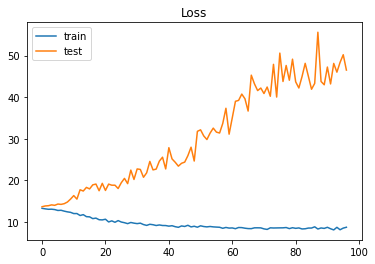

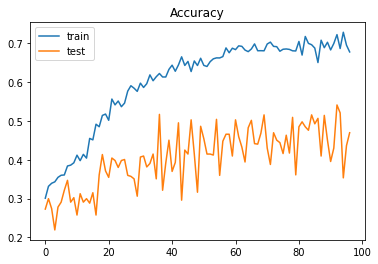





2


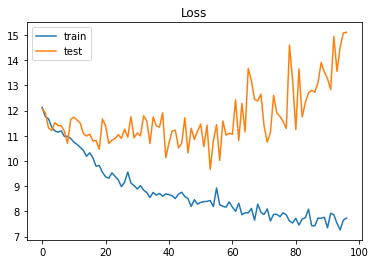

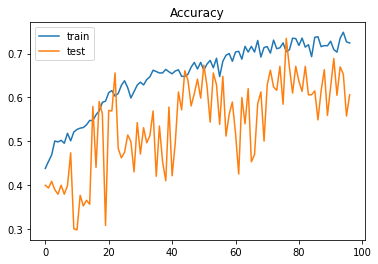





3


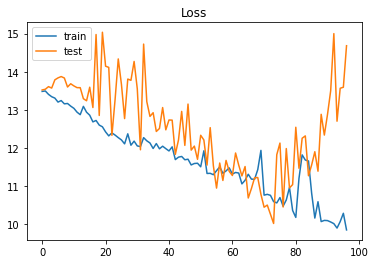

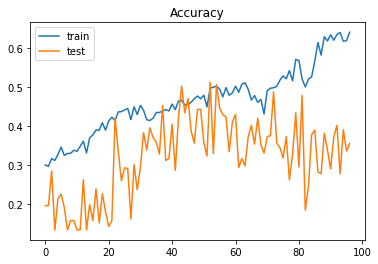





4


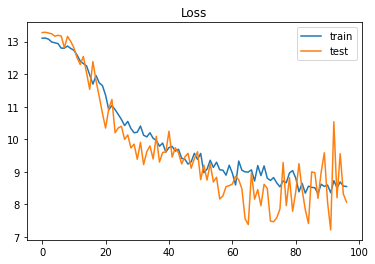

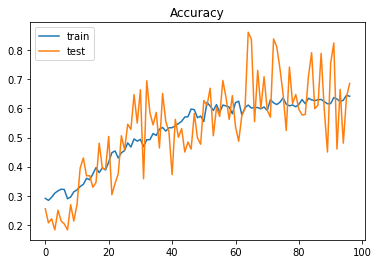





5


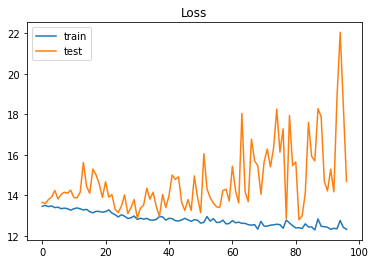

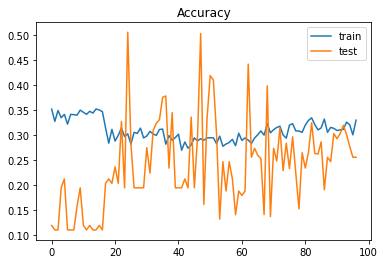





6


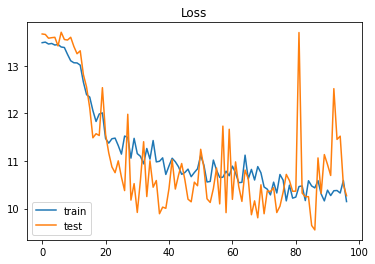

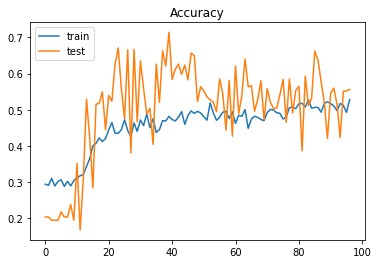





7


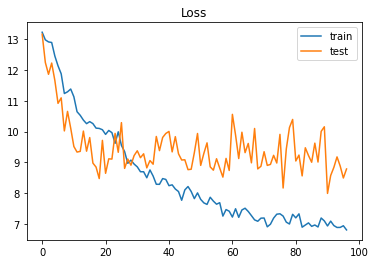

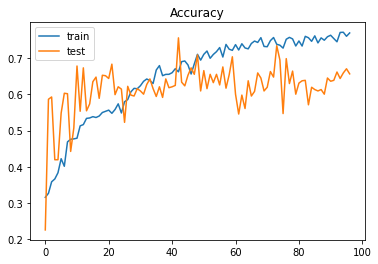





8


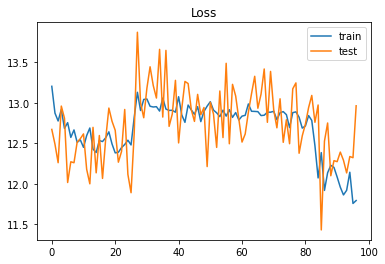

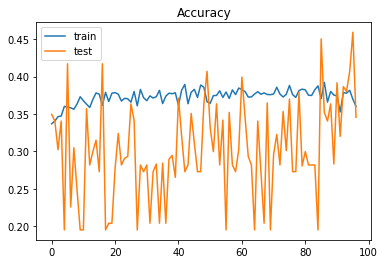





9


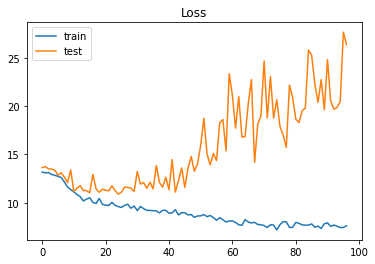

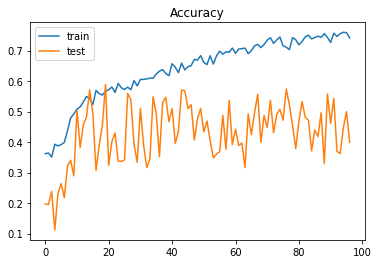





10


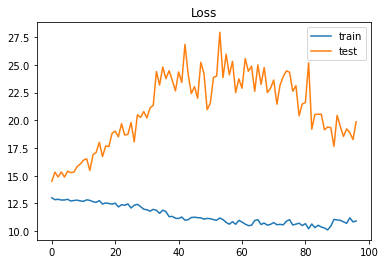

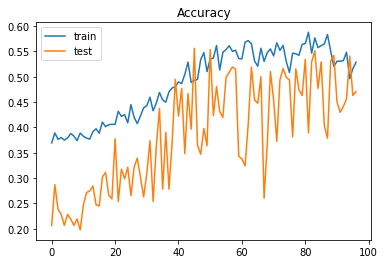





11


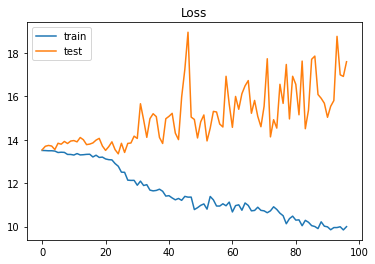

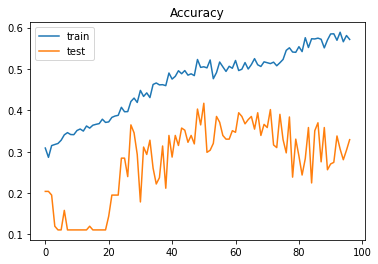





12


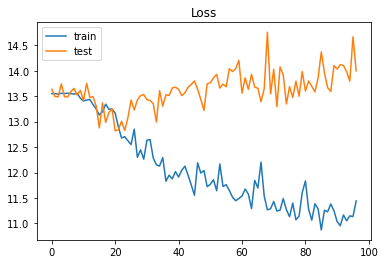

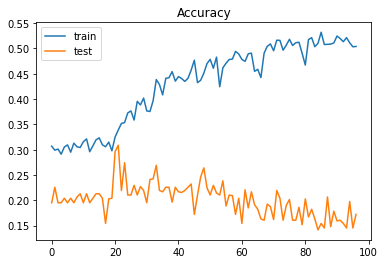





13


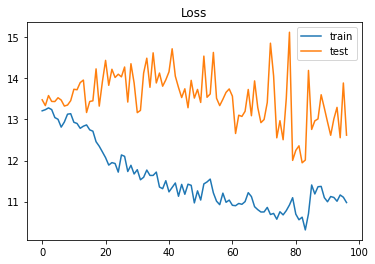

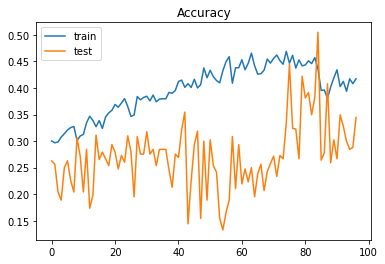





14


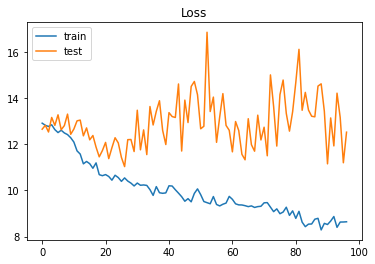

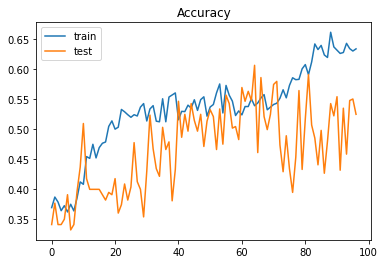





15


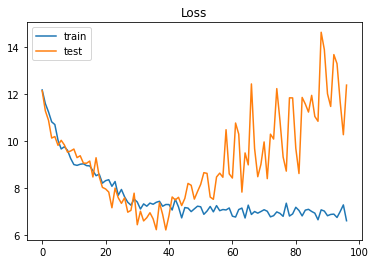

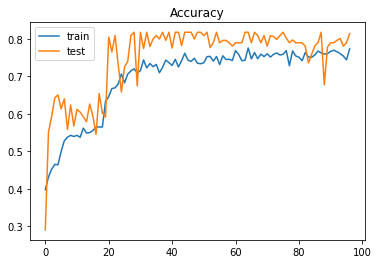

In [ ]:
show_results(subject_dependent_result)

---
We now repeat the same process for the subject independent training. Here we apply a cross-validation process, by choosing a different subject every time for the testing and using the remaining ones for the training.

The testing set, in its unlabeled state, is also used for the adversarial training in NodeDAT, by re-picking randomly a batch of samples for each training samples.

In [ ]:
subject_independent_result = subject_independent_training(indep_loader)
text_indep_res = json.dumps(subject_independent_result)

PAZIENTE no. 1 (cross-validation):


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1: TrL=39.6171, TrA=0.2653, TeL=27.1663, TeA=0.2705,
Epoch 5: TrL=26.4751, TrA=0.3152, TeL=26.9211, TeA=0.3183,
Epoch 10: TrL=25.7771, TrA=0.3597, TeL=26.5686, TeA=0.3383,
Epoch 15: TrL=26.3075, TrA=0.3052, TeL=26.5579, TeA=0.3022,
Epoch 20: TrL=25.4718, TrA=0.3618, TeL=26.9565, TeA=0.2923,
Epoch 25: TrL=24.9953, TrA=0.3819, TeL=26.1651, TeA=0.3456,
Epoch 30: TrL=24.5562, TrA=0.4019, TeL=26.2369, TeA=0.3161,
Epoch 35: TrL=24.6487, TrA=0.3936, TeL=26.1997, TeA=0.3158,
Epoch 40: TrL=24.2790, TrA=0.4111, TeL=25.8509, TeA=0.3891,
Epoch 45: TrL=23.9644, TrA=0.4212, TeL=26.0063, TeA=0.2864,
Epoch 50: TrL=23.8153, TrA=0.4324, TeL=25.7222, TeA=0.3817,
Epoch 55: TrL=23.6335, TrA=0.4345, TeL=25.4669, TeA=0.3980,
Epoch 60: TrL=23.4498, TrA=0.4430, TeL=25.8546, TeA=0.3556,
Epoch 65: TrL=23.2734, TrA=0.4437, TeL=25.6880, TeA=0.3586,
Epoch 70: TrL=23.2190, TrA=0.4442, TeL=25.4984, TeA=0.3979,
Epoch 75: TrL=23.2031, TrA=0.4473, TeL=25.6826, TeA=0.3981,
Epoch 80: TrL=23.0827, TrA=0.4549, TeL=25.

In [ ]:
text_indep_res

'{"1": {"loss_history": {"train": [39.617149692323665, 27.057679042694676, 26.915812878526268, 26.697943554236957, 26.475127213645568, 26.277212384617037, 26.075683319969976, 26.150067544178707, 25.831720218103076, 25.777108795107008, 25.874803641148326, 26.38087552671979, 26.372060777058483, 25.845385943248772, 26.307467868482124, 26.15865086164119, 26.126084144599226, 25.574636295776784, 25.7775613448097, 25.471786832679282, 25.417993076071074, 25.276910456448277, 25.189931215211626, 25.157479399003368, 24.99528887057109, 25.016456443901166, 24.779850728084437, 24.86582612383897, 24.802206025978347, 24.556227554723932, 24.768459664137392, 24.670532993233344, 24.65644557222222, 24.561752856048916, 24.64865751761106, 24.65159623789939, 24.55547724646585, 24.38880414980124, 24.463051858004707, 24.278971733235576, 24.27375368251922, 24.3258192905846, 24.13919452757484, 24.19614250644757, 23.964389872616046, 23.926526461003366, 23.911307351387446, 24.182444789823997, 23.919788006547368, 2

In [ ]:
# For loading from backup file
subject_independent_result = None
with open("/content/drive/My Drive/SEED_IV/RGNN_indep_nonrand_results.json", "r") as f:
  subject_independent_result = json.load(f)

subject_independent_result

{'1': {'accuracy_history': {'test': [0.27052370842179757,
    0.26990445859872614,
    0.27114295824486906,
    0.3068825194621373,
    0.3182944090587403,
    0.2458421797593772,
    0.3241772823779193,
    0.2761854210898797,
    0.33213906581740976,
    0.33828733191790517,
    0.3018842887473461,
    0.3021939136588818,
    0.27649504600141545,
    0.33151981599433833,
    0.3021939136588818,
    0.2761854210898797,
    0.3018842887473461,
    0.35323779193205945,
    0.3021939136588818,
    0.29233014861995754,
    0.3560686482661005,
    0.345276008492569,
    0.30157466383581033,
    0.3385084925690021,
    0.34558563340410475,
    0.3341295116772824,
    0.3428874734607219,
    0.36257077140835103,
    0.34638181174805377,
    0.3161270346779901,
    0.3227618542108988,
    0.29432059447983017,
    0.3488588110403397,
    0.2940109695682944,
    0.3158174097664544,
    0.34567409766454354,
    0.35261854210898796,
    0.31055378627034674,
    0.3045824486907289,
    0.389065817

In [ ]:
# Redefining to account for the reduced number of subjects:
def graph_res(i, res):
  loss_history = res[i]["loss_history"]
  accuracy_history = res[i]["accuracy_history"]

  # Plot loss history
  plt.title("Loss")
  for split in ["train", "test"]:
    plt.plot(loss_history[split][3:], label=split)
  plt.legend()
  plt.show()

  # Plot accuracy history
  plt.title("Accuracy")
  for split in ["train", "test"]:
    plt.plot(accuracy_history[split][3:], label=split)
  plt.legend()
  plt.show()

def show_results(res):
  for i in [1]:
    print(i)
    graph_res(str(i), res)
    print("\n\n\n")

1


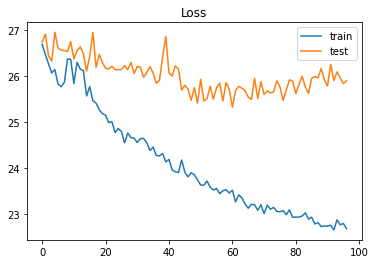

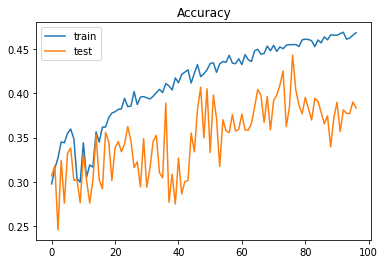

In [ ]:
show_results(subject_independent_result)

---
#Commenting the results

We evaluate the average performance in the case of the subject-dependent training. As the authors do not state a criteria for choosing the final accuracy, we simply employ the **final epoch's value**, in order to eliminate some bias on the test results' oscillation.

In [ ]:
accuracies = [subject_dependent_result[str(i)]["accuracy_history"]["test"][-1] for i in range(1,16)]
accuracies = torch.tensor(accuracies)

losses = [subject_dependent_result[str(i)]["loss_history"]["test"][-1] for i in range(1,16)]
losses = torch.tensor(losses)

print(f'''Final accuracy: AVG = {accuracies.mean().item()}, STD = {accuracies.std().item()}
      Final loss: AVG = {losses.mean().item()}, STD = {losses.std().item()}''')

Final accuracy: AVG = 0.46564623713493347, STD = 0.17569096386432648
      Final loss: AVG = 16.429338455200195, STD = 9.472685813903809


The final loss computed on the single tested SIC subject is:

In [ ]:
print(f'''Final accuracy: {subject_dependent_result['1']["accuracy_history"]["test"][-1]}
      Final loss: {subject_dependent_result['1']["loss_history"]["test"][-1]}''')

Final accuracy: 0.46938775510204084
      Final loss: 46.531192273509745


We also want to extract some informations on the size and capacity of the dataset we worked on.

In [ ]:
lengths = [len(indep_loader[i]["list"]) for i in range(1,16)]
lengths

[2505,
 2505,
 2505,
 2505,
 2505,
 2505,
 2505,
 2505,
 2505,
 2505,
 2505,
 2505,
 2505,
 2505,
 2505]

Any descriptive comment on the obtained results is included in our presentation on the paper, as the Cognitive Computing 2020/21 course's final assignment.